In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time

from ChemClean import *
from Descriptors import *

In [2]:
import rdkit.Chem as Chem
from rdkit.Chem import rdMolDescriptors 

In [3]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

import statsmodels.api as sm

## Load data from url

In [4]:
url='https://raw.githubusercontent.com/akashjn/DataScience/main/Data/BTZ_5442mols_smiles_redpot.csv'
data=pd.read_csv(url)

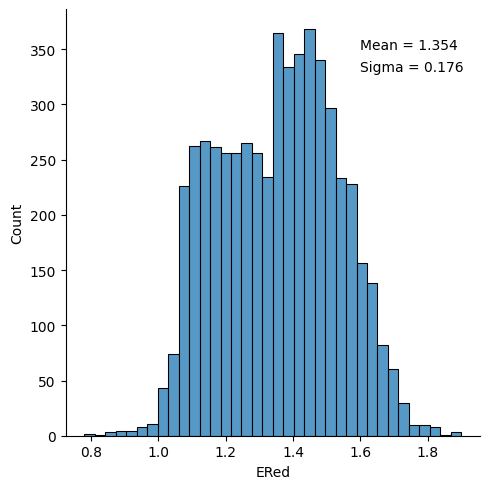

In [5]:
ax=sns.displot(data, x="ERed")
plt.text(1.6,350,'Mean = '+str(np.round(np.mean(data['ERed']),3)))
plt.text(1.6,330,'Sigma = '+str(np.round(np.std(data['ERed']),3)))
plt.show()

## Generate descriptors using Descriptors.py

In [6]:
%%time
p=desc(data['SMILES'][:100])
df_rdkit=p.RDkit_descriptors()
print(df_rdkit.shape)
df_rdkit.head()

(100, 208)
CPU times: user 557 ms, sys: 19.6 ms, total: 577 ms
Wall time: 572 ms


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,4.456023,1.020889,4.456023,1.020889,0.861773,291.424,270.256,291.151767,108,0,...,0,0,0,0,0,0,0,0,0,0
1,5.243940,0.748371,5.243940,0.748371,0.864637,292.408,272.248,292.135782,108,0,...,0,0,0,0,0,0,0,0,0,0
2,4.487068,0.475834,4.487068,0.475834,0.941806,291.424,270.256,291.151767,108,0,...,0,0,0,0,0,0,0,0,0,0
3,4.513689,0.897986,4.513689,0.897986,0.918901,305.451,282.267,305.167417,114,0,...,0,0,0,0,0,0,0,0,0,0
4,4.512897,0.476118,4.512897,0.476118,0.939652,305.451,282.267,305.167417,114,0,...,0,0,0,0,0,0,0,0,0,0


## Data cleaning operations from ChemClean.py

In [7]:
p=clean(df_rdkit)

In [8]:
p.remove_nan().head()
p.remove_unique().head()
p.remove_columns_low_std(0.2).head()
df_model=p.remove_corr_features()
print(df_model.shape)
df_model.head()

Removing 0 columns with nan, if any
Before: df.shape=(100, 208)
After: df.shape=(100, 208) 

removing 100 columns values with a unique value
Before: df.shape=(100, 208)
After: df.shape=(100, 108) 

Removed 24 columns with std < 0.2 
Dropped 78 features with correlation coeff. > 0.50
(100, 6)


,MaxEStateIndex,MolWt,PEOE_VSA10,SMR_VSA3,SMR_VSA4,EState_VSA7
0,4.456023,291.424,11.033401,13.64699,0.0,0.0
1,5.243940,292.408,11.033401,8.74708,0.0,0.0
2,4.487068,291.424,11.033401,8.74708,0.0,0.0
3,4.513689,305.451,11.033401,8.74708,0.0,0.0
4,4.512897,305.451,11.033401,8.74708,0.0,0.0


In [11]:
p=0.05
target=data['ERed'][:100]
features=df_model.copy()
features.shape

(100, 6)

In [12]:
for a in range(100):
    mod = sm.OLS(target,features)
    fii = mod.fit()
    p_values = fii.summary2().tables[1]['P>|t|']
    cols=[]
    for i in range(len(p_values)):
        if p_values[i]>p:
            cols.append(p_values.index[i])
    if len(cols)==0:
        break
    print(len(cols),'descriptors eliminated in iteration',str(a+1))
    features.drop(columns=cols,inplace=True)
    
print('Final model has',features.shape,'desriptors')
features.columns

2 descriptors eliminated in iteration 1
Final model has (100, 4) desriptors


Index(['MaxEStateIndex', 'MolWt', 'PEOE_VSA10', 'SMR_VSA3'], dtype='object')

Index(['MaxEStateIndex', 'MinEStateIndex', 'PEOE_VSA1', 'PEOE_VSA10',
       'PEOE_VSA11', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA3', 'SlogP_VSA3',
       'SlogP_VSA6', 'EState_VSA3', 'EState_VSA7', 'NumAliphaticHeterocycles'],
      dtype='object')